앞서 사용했던 iris데이터를 사용해서 회귀분석을 해보자.

iris데이터는 아래 URL에서 읽어올 수 있다.

```

import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

```

독립변수는 petal_length 컬럼, 종속변수는 petal_width 컬럼으로 해보자.

## (1) DataFrame 생성

In [1]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [2]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## (2) 회귀선 그래프

In [8]:
x = iris['petal_length']
y = iris['petal_width']

In [11]:
import numpy as np

X = np.array([np.ones(len(x)), x])
X = X.T

In [14]:
w0, w1 = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

In [16]:
print(f"w0: {w0}, w1: {w1}")

w0: -0.3665140452167314, w1: 0.41641913228540195


In [17]:
yhat = w0 + w1*x

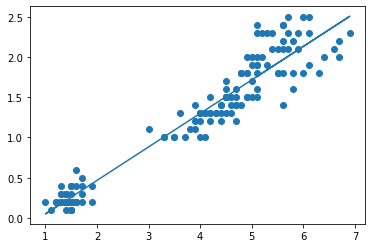

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(x,y)
ax.plot(x,yhat)

## (3) Spark를 사용하여 회귀분석하고 계수 출력

In [19]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [35]:
irisDf = spark.createDataFrame(iris)

In [31]:
(trainDf, testDf) = irisDf.randomSplit([0.6, 0.4])

In [49]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="species", outputCol="speciesIndex")

In [50]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="speciesIndex", outputCol="speciesVec")

In [59]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols = ["speciesVec", "sepal_length","sepal_width","petal_length", "petal_width"], outputCol = 'features')

In [60]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='petal_width', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [61]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])

In [62]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

In [63]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [-0.008790754031281838,0.0,0.0,0.0,0.09233713016167494,0.42422525245275106]
Intercept: 0.346


## (4) 실제와 예측 출력

In [57]:
modelTestDf=model.transform(testDf)

In [58]:
modelTestDf.select('petal_width','prediction').show(10)

+-----------+------------------+
|petal_width|        prediction|
+-----------+------------------+
|        0.2|0.5425431259823417|
|        0.2|0.5517768389985092|
|        0.1|0.5185880267694001|
|        0.2|0.5517768389985092|
|        0.6|0.7399343660119503|
|        0.2|0.5517768389985092|
|        0.3|0.5941993642437856|
|        0.4|0.6458556025052298|
|        0.3|0.6034330772599531|
|        0.2|0.5702442650308441|
+-----------+------------------+
only showing top 10 rows



## (5) 정확성 평가하고 출력

In [64]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="rmse")

In [65]:
rmse=evaluator.evaluate(modelTestDf)

In [66]:
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.270'

In [67]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="r2")

In [68]:
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.863'